In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import calendar
import random 
import seaborn as sn
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://robjhyndman.com/hyndsight/detecting-seasonality/
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm

from pandas.plotting import autocorrelation_plot

import warnings
import itertools

import statsmodels

print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [39]:
import sys
sys.path.insert(0, '../src/forecaster')
from forecaster import Forecaster
import forecaster
forecaster.__version__
#?forecaster

'0.1.0'

              co2
count  526.000000
mean   339.624826
std     17.110954
min    313.400000
25%    324.025000
50%    337.912500
75%    354.537500
max    373.800000

Frequency: MS 12


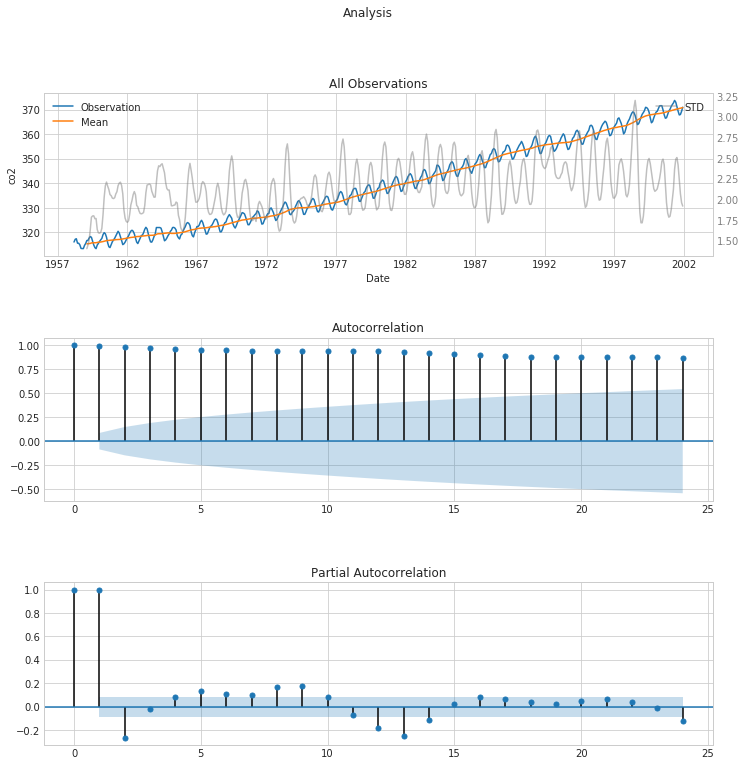

ADF Statistic: 2.359810
p-value: 0.998990
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
{'stationary': False}


In [40]:
def do_analysis(ts, cname="total_value"):
    
    print(ts.describe())
    
#    try:
#        ts.plot(kind='kde')
#    except:
#        pass

    pf = pd.infer_freq(ts.index)
    periods = 12 if pf == "MS" else 1
    print("\nFrequency: {} {}".format(pf, periods))
    
    
    #fig = plt.figure(figsize=(12,8))
    fig, axarr = plt.subplots(3, sharex=False, sharey=False, figsize=(12,12))
    fig.suptitle("Analysis")
    fig.subplots_adjust(hspace=.5)

    ax_ts = axarr[0]
    ax_acf = axarr[1]
    ax_pacf = axarr[2]
    
    fig = ax_ts.plot(ts, label="Observation")
    ax_ts.plot(ts.rolling(periods).mean(), label="Mean")
    ax_std = ax_ts.twinx()
    ax_std.tick_params(axis='y', labelcolor="gray", right=False, grid_alpha=0)
    #ax_std.set_ygridlines([])
    
    ax_std.plot(ts.rolling(periods).std(), label="STD", color="gray", alpha=0.5)
    
    ax_ts.set(xlabel='Date', ylabel=ts.columns[0])
    ax_ts.set_title("All Observations")
    ax_ts.legend()
    ax_std.legend()
    
    try:
        sm.graphics.tsa.plot_acf(ts, lags=24, ax=ax_acf)
    except:
        print ("Error creating ACF - Check the data")
        pass


    try: 
        sm.graphics.tsa.plot_pacf(ts, lags=24, ax=ax_pacf)
    except:
        print ("Error creating PACF - Check the data")
        pass
    
    
    
    #autocorrelation
    #autocorrelation_plot(ts)
    plt.show()
    
    
    
    adf = adfuller(ts[cname])
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    
       
    stationary = adf[0] < adf[4]["5%"]
    
    return {'stationary': stationary}

def test_doanalysis():
    co2 = pd.DataFrame(sm.datasets.co2.load().data)
    co2["date"] = co2["date"].apply(lambda b: datetime.datetime(int(b[0:4]),int(b[4:6]),int(b[6:])))
    co2 = co2.set_index('date')
    co2 = co2.resample('MS').mean()
    co2 = co2.fillna(co2.bfill())

    print(do_analysis(co2, "co2"))

    return 
test_doanalysis()


In [41]:
# https://machinelearningmastery.com/make-sample-forecasts-arima-python/

def differentiate(series, periods=12):
    # df: dataframe containing series to be differentiased
    # periods: periods per season
    diff = series - series.shift(+periods)
    diff.dropna(inplace=True)
    return diff


# add back original value to undo the differnatition
def revert_diff(series, new_series, periods=12):
    # grab the right windows form historical data
    adj = series[-periods:]
    adj = adj[:len(new_series)]
    # add the date to the new_data
    adj = adj.values + new_series.values
    return pd.DataFrame(data=adj, index=new_series.index)[0] 


def remove_seasonality(series, periods=12):
    return differentiate(series, periods)

def add_seasonality(series, new_series, periods=12):
    return revert_diff(series, new_series, periods)

def remove_trend(series):
    return differentiate(series, periods=1)


def add_trend(series, new_series):
    # grab last observation
    last_obs = series.iloc[-1]
    adj = [0] * len(new_series)
    adj[0] = last_obs + new_series[0]
    for i in range(1, len(new_series)):
        adj[i] = adj[i-1] + new_series.values[i]
        
    return pd.DataFrame(data=adj, index=new_series.index).iloc[:,0] 


y = [12*z+x for z in range(0,3) for x in range(1,13)]
t = [datetime.datetime(y,m,1) for y in range(2000,2003) for m in np.arange(1,13)]
y = pd.DataFrame(y, index=t)
y_diff = differentiate(y[0], 1)
assert( y_diff.sum()==35)

t = [datetime.datetime(y,m,1) for y in range(2004,2005) for m in np.arange(1,13)]
forecast = pd.DataFrame([1] * 12, index=t)
r = add_trend(y[0], forecast[0])

#assert(r.sum()==24)
r


2004-01-01    37
2004-02-01    38
2004-03-01    39
2004-04-01    40
2004-05-01    41
2004-06-01    42
2004-07-01    43
2004-08-01    44
2004-09-01    45
2004-10-01    46
2004-11-01    47
2004-12-01    48
Name: 0, dtype: int64

# Stationary 1

### Constant

       total_value
count    60.000000
mean   1003.886167
std       0.000000
min    1003.886167
25%    1003.886167
50%    1003.886167
75%    1003.886167
max    1003.886167

Frequency: MS 12
Error creating PACF - Check the data


/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


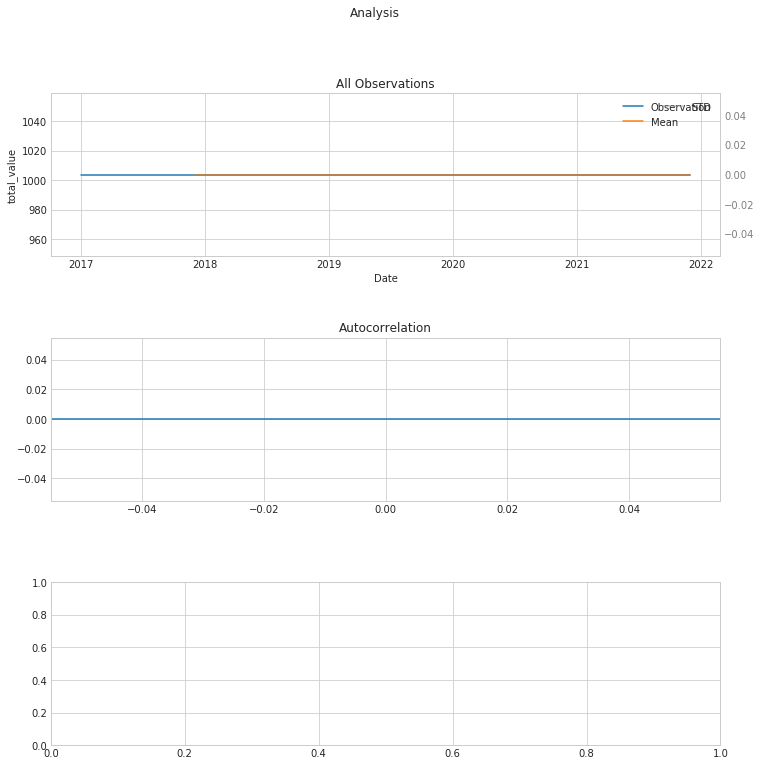

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


{'stationary': False}

In [42]:
A = 1000.
years = 5
year0 = 2017
months = 12 * years

x = [datetime.datetime(y,m,15) for y in range(year0, year0+years) for m in range(1,13)]
t = np.arange(0,months,1.)
y = [A+10.0*random.random()]*months

ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()

k1=ts
do_analysis(ts)


### Constant Growth

       total_value
count     60.00000
mean    3950.00000
std     1746.42492
min     1000.00000
25%     2475.00000
50%     3950.00000
75%     5425.00000
max     6900.00000

Frequency: MS 12


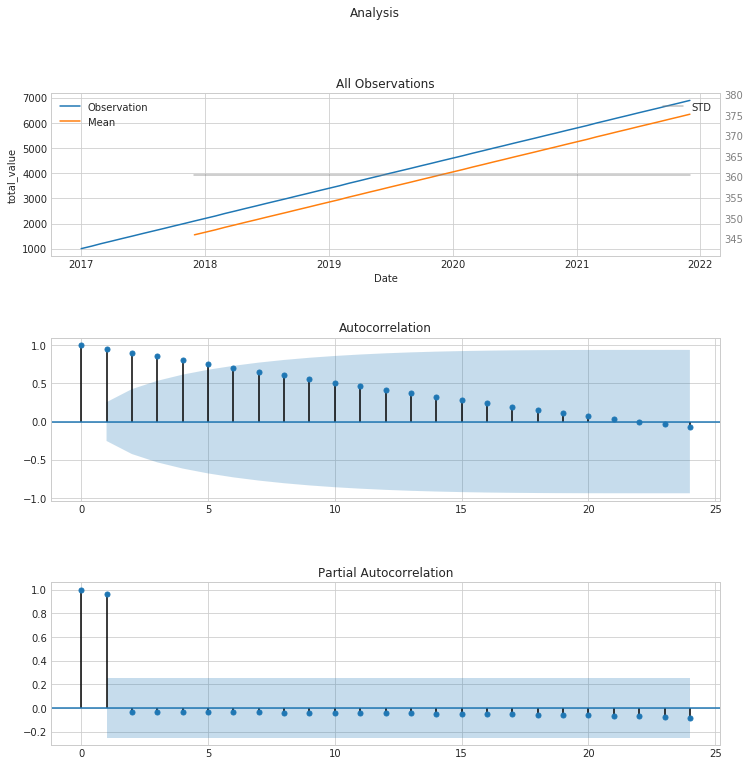

ADF Statistic: 2.156502
p-value: 0.998845
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


{'stationary': False}

In [43]:
A = 1000.
years = 5
year0 = 2017
months = 12. * years

x = [datetime.datetime(y,m,15) for y in range(year0, year0+years) for m in range(1,13)]
t = np.arange(0,months,1.)
y = A*t/10.0+1000

ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()

linear1=ts
do_analysis(ts)


### Sinusoidal

/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


       total_value
count    60.000000
mean   4000.000000
std    3565.370164
min   -1000.000000
25%    1042.468245
50%    4000.000000
75%    6957.531755
max    9000.000000

Frequency: MS 12


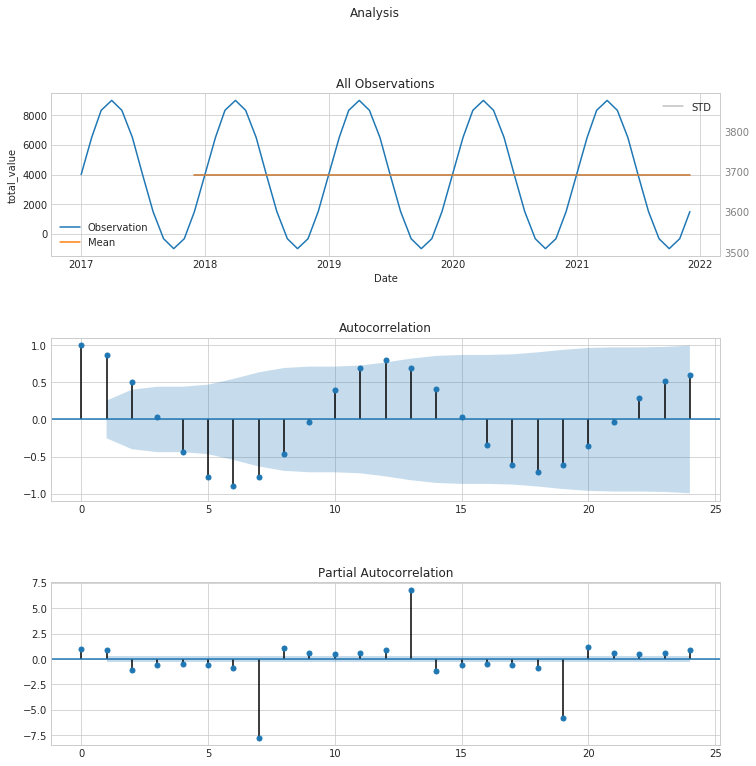

ADF Statistic: -74495276467374.781250
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


{'stationary': True}

In [44]:
A = 5000.
years = 5
year0 = 2017
months = 12. * years

x = [datetime.datetime(y,m,15) for y in range(year0, year0+years) for m in range(1,13)]
t = np.arange(0,months,1.)
y = A*np.sin(5.*2.*np.pi*t/months)+4000

ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()

sine1=ts
do_analysis(ts)

#diff = differentiate(ts["total_value"],12)
#_ = plt.plot(diff)

#do_analysis(pd.DataFrame(diff, columns=["total_value"]))


In [45]:
A = 5000.
years = 15
year0 = 2017
months = 12. * years

x = [datetime.datetime(y,m,15) for y in range(year0, year0+years) for m in range(1,13)]
t = np.arange(0,months,1.)
y = A*np.sin(15.*2.*np.pi*t/months)+4000 + A*np.cos(8.*2.*np.pi*t/months)

ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()

sincos1 = ts
#do_analysis(ts)


# Trend

        total_value
count     60.000000
mean   11800.000000
std     7343.109191
min    -1400.000000
25%     5730.127019
50%    11750.000000
75%    17867.468245
max    25400.000000

Frequency: MS 12


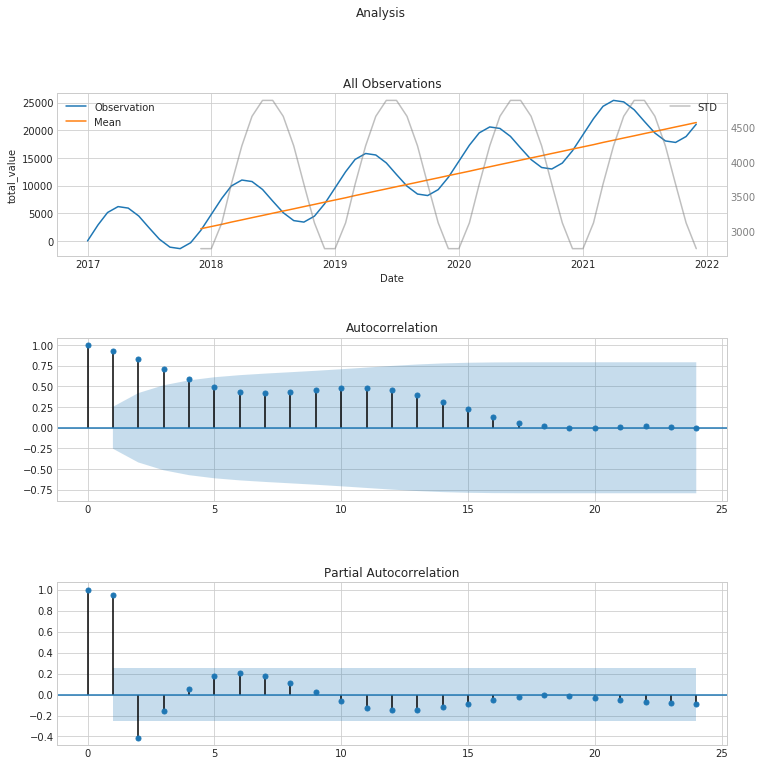

ADF Statistic: 0.490734
p-value: 0.984589
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
{'stationary': False}
       total_value
count    59.000000
mean    357.627119
std    1831.741032
min   -2100.000000
25%   -1430.127019
50%    -269.872981
75%    2230.127019
max    2900.000000

Frequency: MS 12


/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


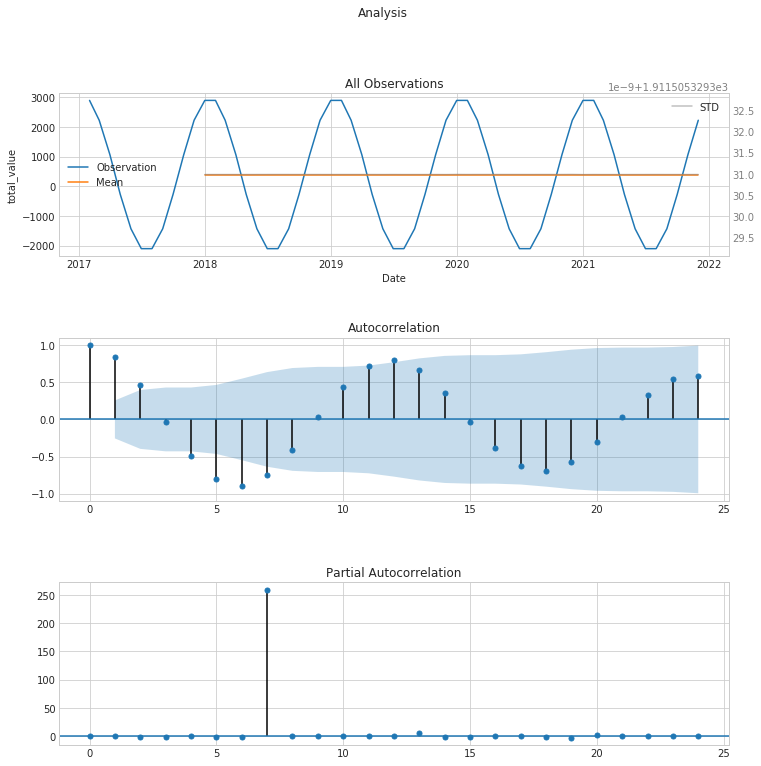

ADF Statistic: -33374693031596.589844
p-value: 0.000000
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


{'stationary': True}

In [46]:
A = 5000.
years = 5
year0 = 2017
months = 12. * years
t = np.arange(0,months,1.)
x = [datetime.datetime(y,m,15) for y in range(year0, year0+years) for m in range(1,13)]
y = A*np.sin(5.*2.*np.pi*t/months)+400*t
ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()
trend1 = ts
print(do_analysis(ts))

diff = remove_trend(ts["total_value"])

do_analysis(pd.DataFrame(diff, columns=["total_value"]))



# Seasonality

        total_value
count  6.000000e+01
mean  -2.691191e+02
std    3.600569e+03
min   -5.000000e+03
25%   -4.330127e+03
50%   -1.836970e-12
75%    2.957532e+03
max    5.000000e+03

Frequency: MS 12


/home/jose/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


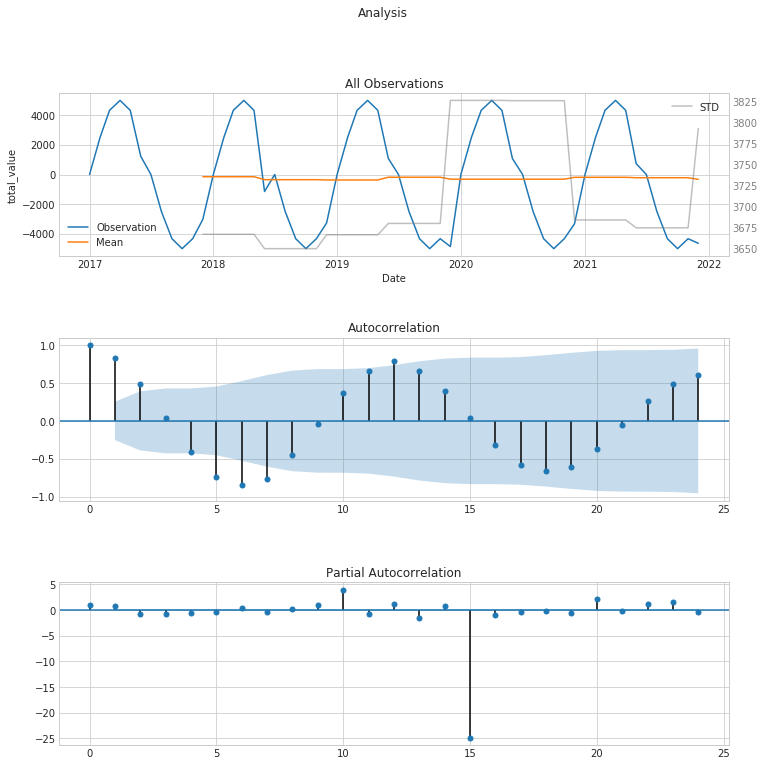

ADF Statistic: -2.313456
p-value: 0.167665
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
{'stationary': False}
        total_value
count  4.800000e+01
mean  -4.387021e+01
std    6.063328e+02
min   -2.374321e+03
25%   -4.826990e-12
50%    0.000000e+00
75%    1.224647e-12
max    2.231199e+03

Frequency: MS 12


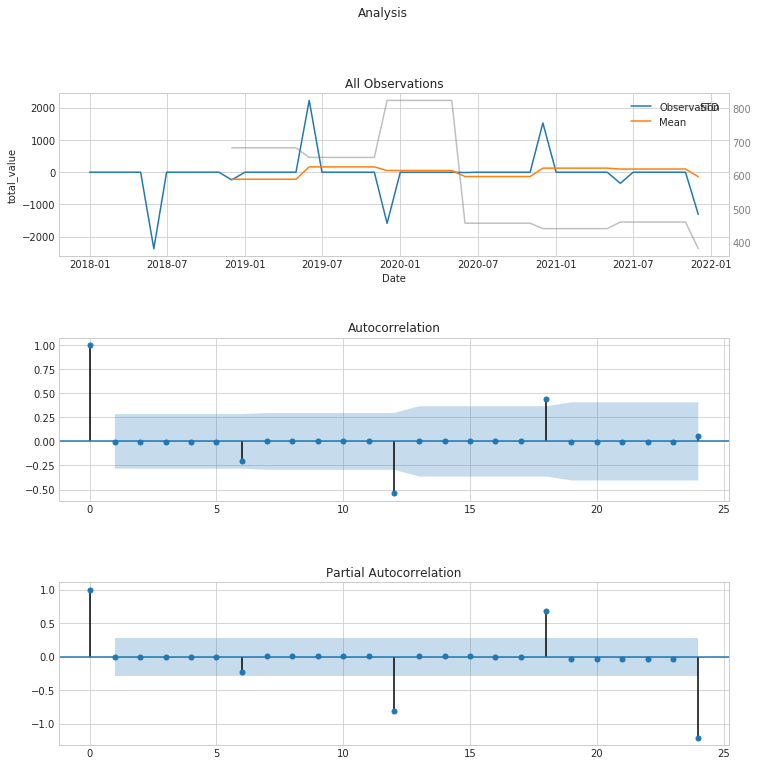

ADF Statistic: -6.397185
p-value: 0.000000
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
{'stationary': True}


In [47]:
A = 5000.
years = 5
year0 = 2017
months = 12. * years

x = [datetime.datetime(y,m,1) for y in range(year0, year0+years) for m in range(1,13)]
t = np.arange(0,months,1.)
y = A*np.sin(5.*2.*np.pi*t/months) 
y = y + [-A * (random.uniform(0.1,1.0)) if a.month%6==0 else 0 for a in x ]

ts =pd.DataFrame(data=y,index=x,columns=["total_value"])
ts = ts.resample("MS").mean()
print(do_analysis(ts))

diff = remove_seasonality(ts["total_value"], 12)
print(do_analysis(pd.DataFrame(diff, columns=["total_value"])))

seasonal1 = ts

              co2
count  526.000000
mean   339.624826
std     17.110954
min    313.400000
25%    324.025000
50%    337.912500
75%    354.537500
max    373.800000

Frequency: MS 12


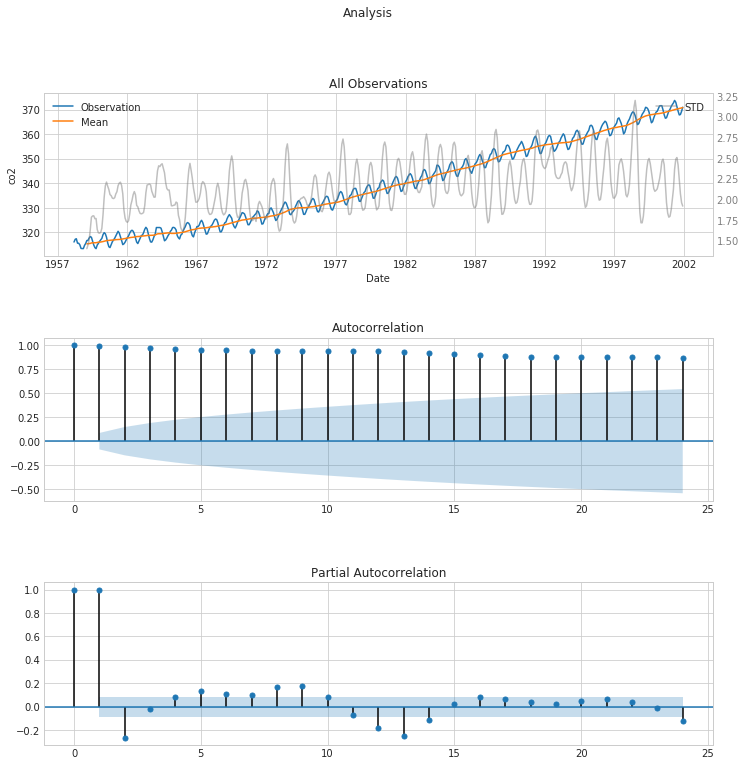

ADF Statistic: 2.359810
p-value: 0.998990
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
{'stationary': False}
remove seasonality
              co2
count  514.000000
mean     1.295840
std      0.697465
min     -1.550000
25%      0.840417
50%      1.247500
75%      1.700000
max      3.775000

Frequency: MS 12


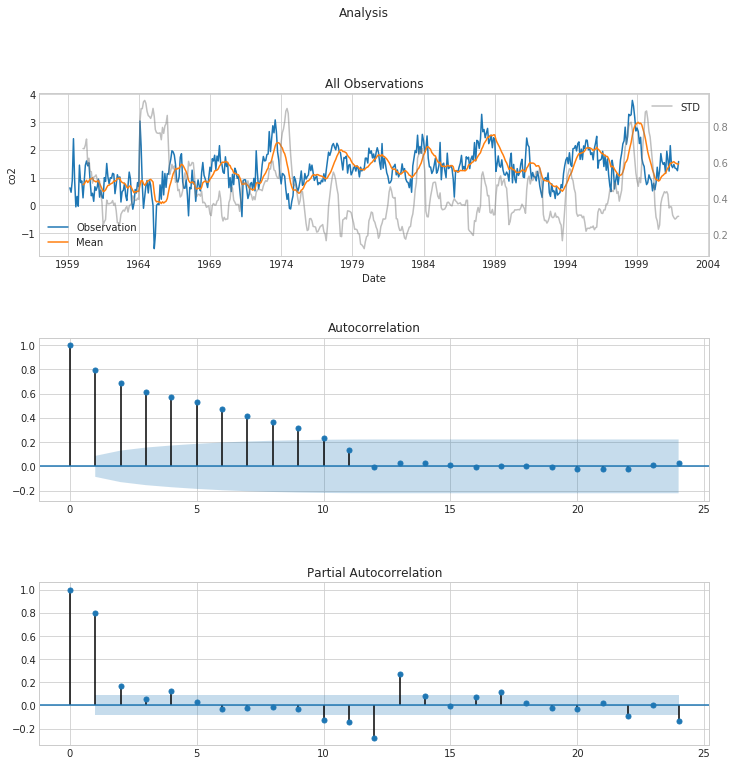

ADF Statistic: -4.626245
p-value: 0.000116
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


{'stationary': True}

In [48]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
co2 = pd.DataFrame(sm.datasets.co2.load().data)
co2["date"] = co2["date"].apply(lambda b: datetime.datetime(int(b[0:4]),int(b[4:6]),int(b[6:])))
co2 = co2.set_index('date')
co2 = co2.resample('MS').mean()
co2 = co2.fillna(co2.bfill())

print(do_analysis(co2, "co2"))

print("remove seasonality")
do_analysis(remove_seasonality(co2, 12), "co2")



# Real World Data

In [49]:
#opt = pd.read_csv("d:/repos/forecast/data/oppty_by_sku.csv", sep="|", skiprows=[1])
#opt.dropna(inplace=True)

In [62]:
opt = pd.read_csv("~/repos/repos/forecast/oppty_by_sku.csv", sep="|", skiprows=[1])
opt.dropna(inplace=True)
opt["date"] = opt.apply(lambda r: datetime.datetime(int(r["Year"]),int(r["Month"]),1), axis=1)
opt = opt[opt["date"]<datetime.datetime(2018,1,1)]
opt = opt.set_index("date")

In [64]:

#opt = opt["ActualValue"]
opt= opt.groupby("date").sum()["ActualValue"]
opt.head()
opt = pd.DataFrame(opt)
opt = opt.resample('MS').mean()
opt.tail()

,ActualValue
date,
2017-08-01,1.201084e+10
2017-09-01,1.102844e+10
2017-10-01,8.413624e+09
2017-11-01,5.957782e+09
2017-12-01,1.486971e+10


        ActualValue
count  7.800000e+01
mean   1.352742e+10
std    9.210665e+09
min    3.435875e+09
25%    7.070101e+09
50%    1.100069e+10
75%    1.595245e+10
max    4.350553e+10

Frequency: MS 12


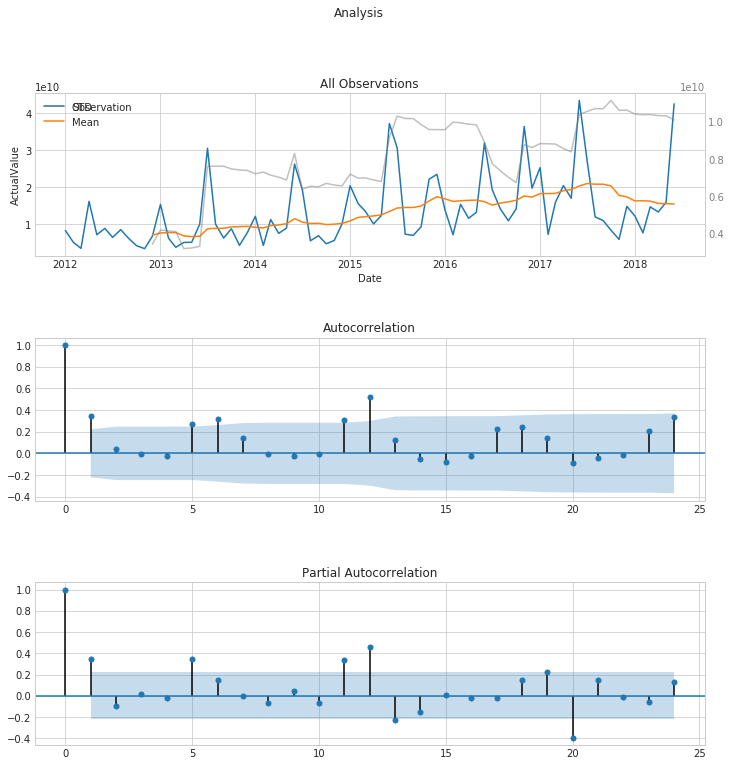

ADF Statistic: -1.364267
p-value: 0.599282
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
{'stationary': False}
        ActualValue
count  7.700000e+01
mean   4.446684e+08
std    1.006567e+10
min   -2.333212e+10
25%   -3.793490e+09
50%   -7.937060e+08
75%    4.525180e+09
max    2.661554e+10

Frequency: MS 12


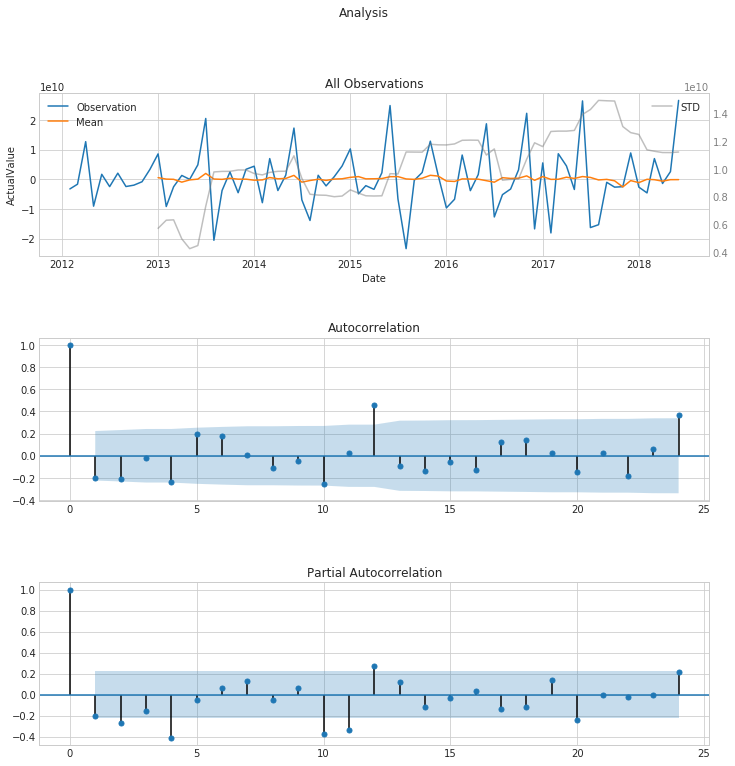

ADF Statistic: -6.166342
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
{'stationary': True}


In [52]:

print(do_analysis(opt, "ActualValue"))
print(do_analysis(remove_trend(opt), "ActualValue"))
#print(do_analysis(remove_seasonality(remove_trend(opt), 12), "ActualValue"))

rw1 = opt
#print(rw1.index)


# TESTS

In [65]:
#y = co2 
#y = seasonal1
#y = sine1
# y=k1 # investigate plotting error 
#y=linear1


test_cutoff = 12
y_full = rw1 
y_obs = rw1[:-test_cutoff]
use_arima_diff = True
if use_arima_diff:
    y_train = y_obs["ActualValue"]
else:
    y_diff1 = remove_trend(y_obs["ActualValue"])
    y_diff2 = remove_seasonality(y_diff1, 12)
    y_train = y_diff2



In [85]:
# CO2
use_arima_diff = True
test_cutoff = 12
y_full = co2
y_obs = co2[:-test_cutoff]
if use_arima_diff:
    y_train = y_obs["co2"]
else:
    y_diff1 = remove_trend(y_obs["co2"])
    y_diff2 = remove_seasonality(y_diff1, 12)
    y_train = y_diff2

In [74]:
f = Forecaster()


order, seasonal_order = f.grid_search(y_train, max_order=(12,2,2,2,2,2,12), progress=lambda x: print("."))
#model = f.train(y_train, order, seasonal_order)
#print(model.summary())
#print(model.summary()) #.tables[1])
print (order, seasonal_order)


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 27

In [66]:
# https://people.duke.edu/~rnau/arimrule.htm

order, seasonal_order = ((12,1,0), (1,1,0,12))

model = f.train(y_train, order, seasonal_order)

order,seasonal_order

((12, 1, 0), (1, 1, 0, 12))

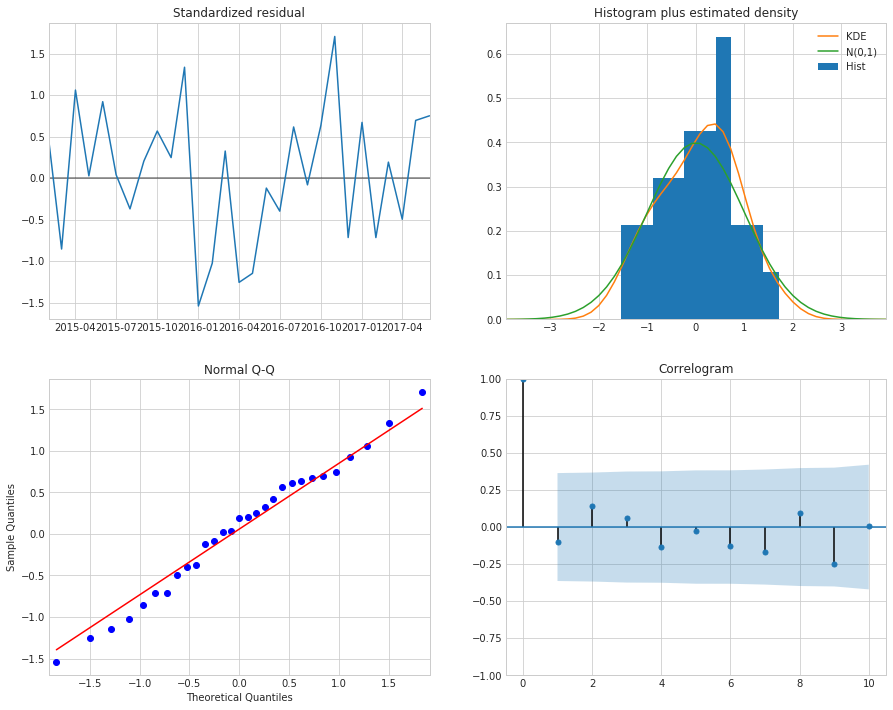

In [67]:
model.plot_diagnostics( figsize=(15, 12), lags=10)
plt.show()

# Forecasting

In [68]:
# Get forecast n steps ahead in future
pred_uc = model.get_forecast(steps=test_cutoff)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

if use_arima_diff:
    y_forecasted = pred_uc.predicted_mean
    uci = pred_ci.iloc[:,1]
    lci = pred_ci.iloc[:,0]
else:
    y_f1 = add_seasonality(y_diff1, pred_uc.predicted_mean)
    y_forecasted = add_trend(y_obs, y_f1)
    
    uci = y_forecasted + pred_ci.iloc[:,1]
    lci = y_forecasted + pred_ci.iloc[:,0]



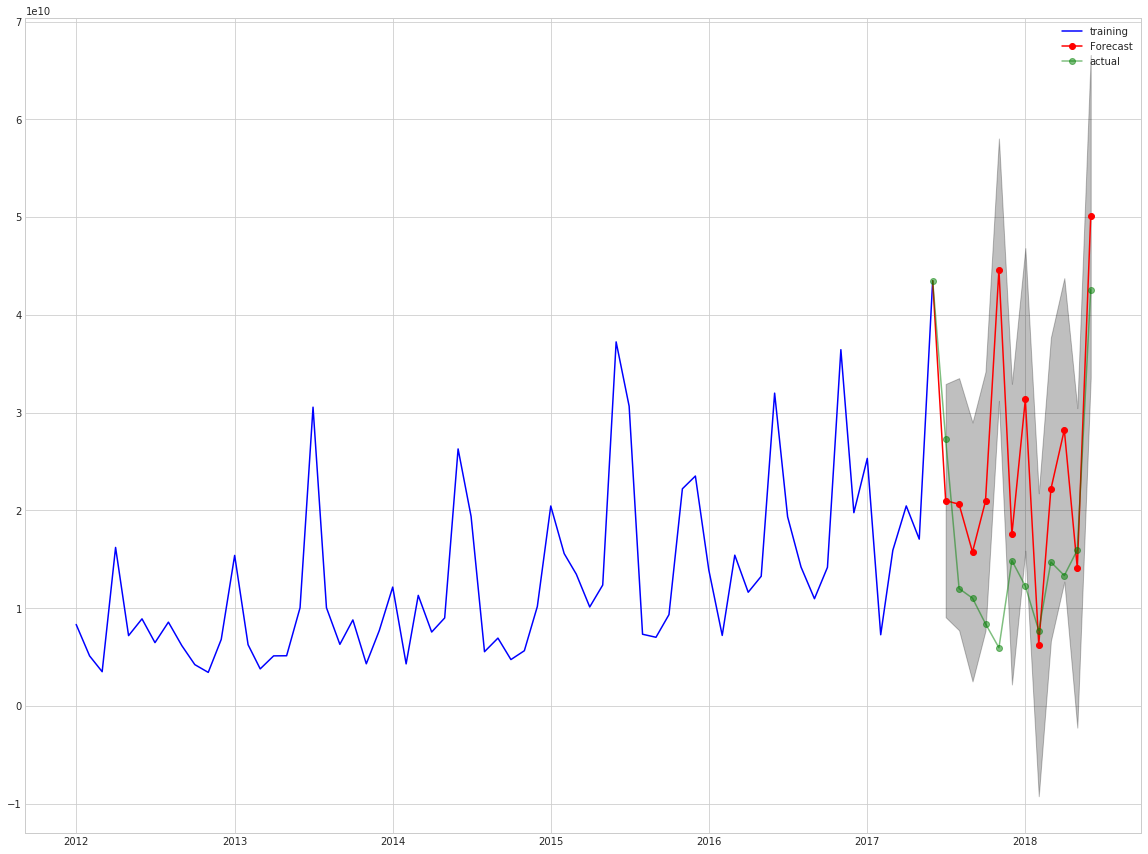

MAE: 1.04831e+10


In [69]:
# copy the series and add a point so the curves (actual and predicted) appear joined
#t = y_train.copy()
sn.set_style("whitegrid")
#sn.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 8})

dt1 = y_obs.index.max() 
yt1 = y_obs.loc[dt1][0]
dt2 = y_forecasted.index.min()
yt2 = y_forecasted.iloc[0]
dt3 = y_forecasted.index.max()
dt3 = datetime.datetime(dt3.year+1 if dt3.month==12 else dt3.year, dt3.month+1 if dt3.month < 12 else 1, 1)

# plot trainig data
_ = plt.figure(figsize=(20, 15))
plt.plot(y_obs[0:], color="blue", label="training")

# plot forecasted
plt.plot(y_forecasted, label='Forecast', color="red", marker="o")

#if uci and lci:
ax = plt.gca()
# fill area between confidence intervals
ax.fill_between(pred_ci.index,
                lci,
                uci, color='k', alpha=.25)


# plot line between last train and first forecasted
plt.plot(pd.DataFrame([[yt1],[yt2]], index = [dt1,dt2]), color="red")


#plt.plot(lci)
#plt.plot(uci)

# plot actual values (for testing purposes) under forecast curve
plt.plot(y_full.iloc[-len(y_forecasted)-1:], color="green", alpha=.5, marker="o", label="actual")

#ax.set_xlabel('Date')
#ax.set_ylabel(y_obs.columns[0])


#xticks = [x for x in y_obs.index.append(y_forecasted.index) if x.month==1 or x.month==7]
#xticks.append(dt3)
#ax.set_xticks(xticks, minor=False)

plt.legend()
plt.show()

actual = y_full.iloc[-len(y_forecasted):]
mae = mean_absolute_error(actual.values, y_forecasted.values)
#rmse = np.sqrt((rw1.iloc[-len(y_forecasted):].values - y_forecasted.values) **2).mean()

print(f"MAE: {mae:n}")


In [ ]:
f = Forecaster()
order, seasonal_order = f.grid_search(y_train, max_order=(1,1,1,0,0,0,12), progress=lambda x: print(x))
print (order)
model = f.train(y_train, order, seasonal_order)
print(model.summary())

#print('ARIMA{}x{} - AIC:{}'.format(order, seasonal_order, error))

In [ ]:
# save model
f.save('model.pkl')

m = f.load('model.pkl')

print(f.forecast(12), f.model.get_forecast(12).predicted_mean)

ETS

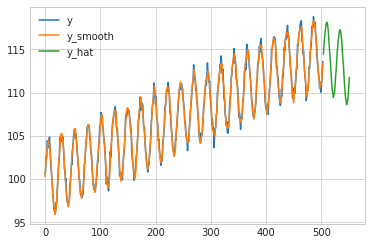

In [22]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error
# https://stackoverflow.com/questions/35192168/alternative-for-rs-exponential-smoothing-state-space-model-in-python-scikit-num
# https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb

m = 24
days = 21
x = np.array(range(days * m)) / (m / 2 / np.pi)
st = 4 * np.sin(x)
lt = np.linspace(0, 15, days * m)
bt = 100
e = np.random.normal(scale=0.5, size=x.shape)

# make the ts we wish to forecast
y = lt + st + bt + e

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(y, trend='add', seasonal='add', 
seasonal_periods=24)
ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta,
smoothing_seasonal=gamma)

# forecast p hours ahead
p_ahead = 48
yh = ets_fit.forecast(p_ahead)

# plot the y, y_smoothed and y_hat ts'
plt.plot(y, label='y')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(range(days * m, days * m + p_ahead),yh, label='y_hat')

plt.legend()
plt.show()

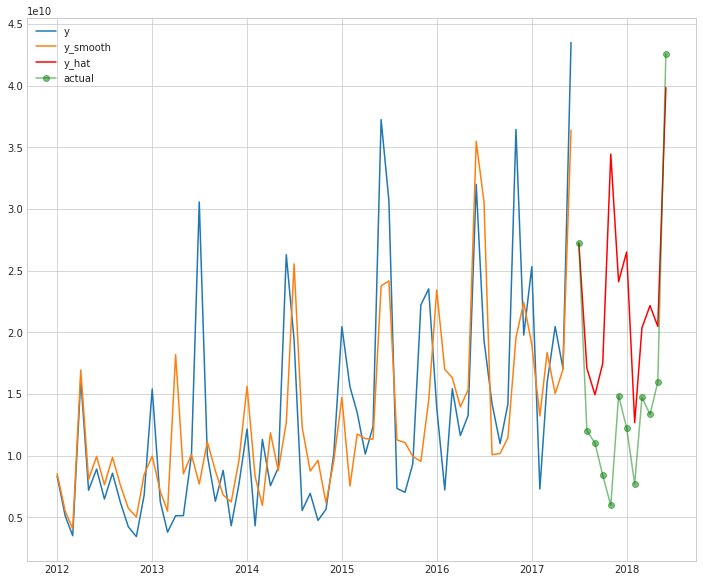

MAE: 8.0644e+09


,ActualValue
date,
2017-07-01,2.727587e+10
2017-08-01,1.201084e+10
2017-09-01,1.102844e+10
2017-10-01,8.413624e+09
2017-11-01,5.957782e+09
2017-12-01,1.486971e+10
2018-01-01,1.226420e+10
2018-02-01,7.711629e+09
2018-03-01,1.472308e+10


In [73]:
# initialise model
alpha = 0.01
beta = 0.01
gamma = 0.1
#ets_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12)
#ets_model = Holt(y_train, exponential=False,damped=False)
#ets_fit = ets_model.fit() #smoothing_level=alpha, smoothing_slope=beta,smoothing_seasonal=gamma)

ets_fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=False)


# forecast p hours ahead
p_ahead = 12
yh = ets_fit.forecast(p_ahead)

# plot the y, y_smoothed and y_hat ts'
plt.figure(figsize=(12,10))
plt.plot(y_train, label='y')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat', color="red")

actual = y_full.iloc[-len(yh):]
plt.plot(actual, color="green", alpha=.5, marker="o", label="actual")

mae = mean_absolute_error(actual.values, yh.values)

plt.legend()
plt.show()

print(f"MAE: {mae:n}")
actual

/home/jose/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/home/jose/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/jose/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


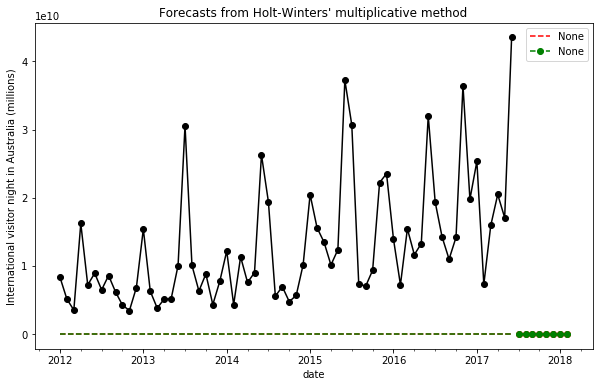

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,1.052632e-01,1.052632e-01,1.052632e-01,1.052632e-01
$\beta$,5.263158e-02,5.263158e-02,5.263158e-02,5.263158e-02
$\phi$,NaN,NaN,0.000000e+00,0.000000e+00
$\gamma$,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
$l_0$,2.664180e-01,2.664180e-01,2.664180e-01,2.664180e-01
$b_0$,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SSE,1.679630e+22,1.679630e+22,1.679630e+22,1.679630e+22


In [65]:
aust = y_train
fit1 = ExponentialSmoothing(aust, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(aust, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(aust, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(aust, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = aust.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(8).plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.")

results